In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import torchvision 
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
import csv
from time import time as tm
from sklearn.model_selection import train_test_split

# import data
full_data = pd.read_csv('mushroom_clean.csv')

# create training and test sets
np.random.seed(0)
train, test = train_test_split(full_data, test_size = 0.2)

print(train.shape)
print(test.shape)

(6499, 23)
(1625, 23)


In [2]:
# set hyperparameters
num_epochs = 25 # Number of times to go through training data
batch_size = 250 # Batch size
epsilon = .001 # Learning rate
test_batch_size = 300 # Batch size to use for test set

# convert data into tensor
train_target = torch.tensor(train['class'].values.astype(np.int0))
train_features = torch.tensor(train.drop('class', axis = 1).values.astype(np.float32)) 
train_tensor = torch.utils.data.TensorDataset(train_features, train_target) 
train_loader = torch.utils.data.DataLoader(dataset = train_tensor, 
                                           batch_size = batch_size, 
                                           shuffle = True)

test_target = torch.tensor(test['class'].values.astype(np.int0))
test_features = torch.tensor(test.drop('class', axis = 1).values.astype(np.float32)) 
test_tensor = torch.utils.data.TensorDataset(test_features, test_target) 
test_loader = torch.utils.data.DataLoader(dataset = test_tensor, 
                                           batch_size = test_batch_size, 
                                           shuffle = True)

In [3]:
# get a batch of data by defining an iterator 
torch.manual_seed(0)
TrainingIterator = iter(train_loader)
X, Y = next(TrainingIterator)
X = X.squeeze()
print("Size of one X batch=", X.size())
print("Size of one Y batch=", Y.size())

Size of one X batch= torch.Size([250, 22])
Size of one Y batch= torch.Size([250])


In [16]:
# network architecture
class mushroom_classifier(nn.Module):
    def __init__(self):
        super(mushroom_classifier, self).__init__()
        self.Lin1 = nn.Linear(22, 15)
        self.Lin2 = nn.Linear(15,10)
        self.Lin3 = nn.Linear(10,1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.Lin1(x)
        out = self.relu(out)
        out = self.Lin2(out)
        out = self.relu(out)
        out = self.Lin3(out)
        out = self.sigmoid(out)
        return out

device='cpu'
model = mushroom_classifier().to(device)

# a custom binary cross entropy function that can specify class costs
def weighted_binary_cross_entropy(y_hat, y, costs=None):   
    if costs is not None:
        loss = costs[1] * (y * torch.log(y_hat)) + costs[0] * ((1 - y) * torch.log(1 - y_hat))
    else:
        loss = y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat)
    return torch.neg(torch.mean(loss))

# convert class costs to tensor
costs = [1.0, 2.0] # false positive, false negative
class_costs = torch.FloatTensor(costs)

# use Adam to optimize
optimizer = torch.optim.Adam(model.parameters(), lr = epsilon)

# compute and print number of trainable parameters
NumParams = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters in model =', NumParams)

Number of parameters in model = 516


In [17]:
steps_per_epoch = len(train_loader)
total_num_steps = num_epochs*steps_per_epoch
LossesToPlot = np.zeros(total_num_steps) # Initialize vector of losses
print("steps per epoch=", steps_per_epoch, "\nnum epochs=", num_epochs, "\ntotal number of steps=", total_num_steps)

steps per epoch= 26 
num epochs= 25 
total number of steps= 650


In [18]:
# initialize test losses
TestLosses = np.zeros(total_num_steps)

j = 0
t1 = tm()

for k in range(num_epochs):
    
    np.random.seed(k)
    TrainingIterator = iter(train_loader)
    
    for i in range(steps_per_epoch):
        # get one batch of training data and send it to the current device        
        X,Y = next(TrainingIterator)
        X = X.to(device)
        Y = Y.to(device)
      
        # forward pass: compute yhat and loss for this batch
        Yhat = model(X)
        Yhat = Yhat.squeeze()
        Loss = weighted_binary_cross_entropy(Yhat, Y, costs=class_costs)
       
        # backward pass and optimize
        optimizer.zero_grad() # zero-out gradients from last iteration
        Loss.backward()       # compute gradients
        optimizer.step()      # update parameters
        
        # store loss and increment counter
        LossesToPlot[j]=Loss.item()

        # compute test losses
        with torch.no_grad():
            TestingIterator = iter(test_loader)
            X,Y = next(TestingIterator)
            X = X.to(device)
            Y = Y.to(device)
            Yhat = model(X)
            Yhat = Yhat.squeeze() 
            TestLosses[j] = weighted_binary_cross_entropy(Yhat, Y, costs = class_costs).item()  

        j+=1
       
t2 = tm()   

print("Training time=",t2-t1,"sec=",(t2-t1)/num_epochs,"sec/epoch=",(t2-t1)/total_num_steps,"sec/step")


Training time= 16.994007110595703 sec= 0.6797602844238281 sec/epoch= 0.02614462632399339 sec/step


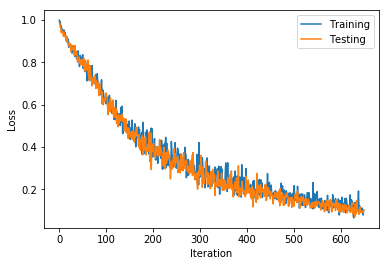

In [19]:
# plot losses
plt.plot(LossesToPlot)
plt.xlabel("Iteration")
plt.ylabel("Loss")

# plot test losses
plt.plot(TestLosses)
plt.legend(['Training','Testing'])

In [20]:
# misclassifications on training & test sets
with torch.no_grad():
    X=train_features.to(device)
    Y=train_target.to(device)
    Yhat=model(X.float())
    PredictedClass = torch.round(Yhat).squeeze()
    TrainingMisclassRate = 1-(PredictedClass == Y).sum().item()/Y.size(0)
    print('Percent of training mushrooms misclassified: {} %'.format(100*TrainingMisclassRate))

    Xtest=test_features.to(device)
    Ytest=test_target.to(device)
    YhatTest=model(Xtest.float())
    PredictedClassTest = torch.round(YhatTest).squeeze()
    TestMisclassRate = 1-(PredictedClassTest == Ytest).sum().item()/Ytest.size(0)
    print('Percent of testing mushrooms misclassified:  {} %'.format(100*TestMisclassRate))

Percent of training mushrooms misclassified: 2.523465148484383 %
Percent of testing mushrooms misclassified:  2.3384615384615337 %


In [21]:
# convert y and yhat to numpy objects
Y_np = Y.cpu().data.numpy()
Y_hat_np = PredictedClass.cpu().data.numpy()

# subset yhat to contain only indices where the true label is 'poisonous'
Yhat_poison = Y_hat_np[Y_np == 1]
# Misclassification rate of poisonous mushrooms
print('Percent of poisonous training mushrooms misclassified: {} %'.format(100*sum(Yhat_poison != 1)/sum(Y_np == 1)))

# subset yhat to contain only indices where the true label is 'edible'
Yhat_edible = Y_hat_np[Y_np == 0]
# misclassification rate of edible mushrooms
print('Percent of edible training mushrooms misclassified: {} %'.format(100*sum(Yhat_edible != 0)/sum(Y_np == 0)))

#############

# repeat above steps for test set

# convert y and yhat to numpy objects
Ytest_np = Ytest.cpu().data.numpy()
Y_hat_test_np = PredictedClassTest.cpu().data.numpy()

# subset yhat to contain only indices where the true label is 'poisonous'
Yhat_test_poison = Y_hat_test_np[Ytest_np == 1]
# Misclassification rate of poisonous mushrooms
print('Percent of poisonous test mushrooms misclassified: {} %'.format(100*sum(Yhat_test_poison != 1)/sum(Ytest_np == 1)))

# subset yhat to contain only indices where the true label is 'edible'
Yhat_test_edible = Y_hat_test_np[Ytest_np == 0]
# misclassification rate of edible mushrooms
print('Percent of edible test mushrooms misclassified: {} %'.format(100*sum(Yhat_test_edible != 0)/sum(Ytest_np == 0)))

Percent of poisonous training mushrooms misclassified: 0.7636016544702513 %
Percent of edible training mushrooms misclassified: 4.171632896305125 %
Percent of poisonous test mushrooms misclassified: 0.7761966364812419 %
Percent of edible test mushrooms misclassified: 3.755868544600939 %


In [10]:
# confusion matrix for training data
from sklearn import metrics
print(metrics.confusion_matrix(y_true = Y.cpu().data.numpy(), y_pred = PredictedClass.cpu().data.numpy()))

# confusion matrix for test data
print(metrics.confusion_matrix(y_true = Ytest.cpu().data.numpy(), y_pred = PredictedClassTest.cpu().data.numpy()))

[[3161  195]
 [  39 3104]]
[[807  45]
 [  6 767]]
